In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.metrics.pairwise import pairwise_distances
import scipy.sparse as sp
import pickle as pkl
import matplotlib.pyplot as plt
scaler = RobustScaler()
import warnings; warnings.filterwarnings('ignore')

### Feature 전처리

In [2]:
data = pd.read_csv('space_feat_raw_v3.csv', encoding='cp949'); data.iloc[:2]

,global_ids,bat_ids,LongName,Label_number,areas,volumes,perimeter,X,Y,Z,aspect_ratio,Boundary_line,surface_areas,ax1s
0,04au2AT9H9jfbPccGosL$R,73966,설비관련공간,33400,5.562478,22.694911,9.449982,2.224991,2.5,4.08,0.889997,4,167.107853,7.363230
1,0mciS8ibbF8ev8nWpsGnhh,87406,설비관련공간,33400,36.473932,204.253453,28.744631,5.314592,8.0,5.60,0.664324,17,181.096000,0.886624


In [3]:
data.columns

Index(['global_ids', 'bat_ids', 'LongName', 'Label_number', 'areas', 'volumes',
       'perimeter', 'X', 'Y', 'Z', 'aspect_ratio', 'Boundary_line',
       'surface_areas', 'ax1s'],
      dtype='object')

- Select features

In [4]:
data = data[['bat_ids','areas', 'volumes','perimeter', 'X', 'Y', 'Z', 'aspect_ratio', 'Boundary_line',
             'surface_areas', 'ax1s', 'Label_number']]

In [5]:
data_ = data.rename(columns={'bat_ids':'id', 'Label_number':'label'}); data_.iloc[:2]

,id,areas,volumes,perimeter,X,Y,Z,aspect_ratio,Boundary_line,surface_areas,ax1s,label
0,73966,5.562478,22.694911,9.449982,2.224991,2.5,4.08,0.889997,4,167.107853,7.363230,33400
1,87406,36.473932,204.253453,28.744631,5.314592,8.0,5.60,0.664324,17,181.096000,0.886624,33400


- 5개 이하의 부재 재거

In [6]:
rare_label = data_.label.value_counts().gt(5)
data_ = data_.loc[data_.label.isin(rare_label[rare_label].index)]

In [7]:
data_pre = data_.iloc[:,1:-1]; data_pre.iloc[:2]

,areas,volumes,perimeter,X,Y,Z,aspect_ratio,Boundary_line,surface_areas,ax1s
0,5.562478,22.694911,9.449982,2.224991,2.5,4.08,0.889997,4,167.107853,7.363230
1,36.473932,204.253453,28.744631,5.314592,8.0,5.60,0.664324,17,181.096000,0.886624


- Scailing

In [8]:
X = data_pre.values
robust = scaler.fit_transform(X)
data_robs = pd.DataFrame(robust); data_robs.iloc[:2]

,0,1,2,3,4,5,6,7,8,9
0,-0.110092,-0.140902,-0.215197,-0.133692,-0.368096,0.446429,-0.119645,-0.250,0.269779,3.019787
1,0.279387,0.648682,0.399932,0.250539,0.595965,1.803571,-0.368623,1.375,0.321558,-0.419074


In [9]:
data_robs.columns = data_pre.columns; data_robs.iloc[:2]

,areas,volumes,perimeter,X,Y,Z,aspect_ratio,Boundary_line,surface_areas,ax1s
0,-0.110092,-0.140902,-0.215197,-0.133692,-0.368096,0.446429,-0.119645,-0.250,0.269779,3.019787
1,0.279387,0.648682,0.399932,0.250539,0.595965,1.803571,-0.368623,1.375,0.321558,-0.419074


- sparse matrix로 변환 후 저장.

In [10]:
feat = sp.csr_matrix(data_robs.values)

In [11]:
# with open('space.feature', 'wb') as f:
#     pkl.dump(feat, f)

### Edge 정보 전처리

In [12]:
data_.iloc[:2]

,id,areas,volumes,perimeter,X,Y,Z,aspect_ratio,Boundary_line,surface_areas,ax1s,label
0,73966,5.562478,22.694911,9.449982,2.224991,2.5,4.08,0.889997,4,167.107853,7.363230,33400
1,87406,36.473932,204.253453,28.744631,5.314592,8.0,5.60,0.664324,17,181.096000,0.886624,33400


In [13]:
id2ind = dict(zip(data_.iloc[:,0], data_.index))

In [14]:
elist = pd.read_csv('space_adj_v3.csv', header=None)

In [15]:
elist = elist.iloc[:, :4]
elist = elist.rename(columns={0:'s1', 1:'s1_label', 2:'s2', 3:'s2_label'})
elist.head()

,s1,s1_label,s2,s2_label
0,99248,IfcColumn,718026,IfcStair
1,99308,IfcColumn,913844,IfcSlab
2,99368,IfcColumn,913844,IfcSlab
3,99428,IfcColumn,87991,IfcSlab
4,99428,IfcColumn,913844,IfcSlab


In [16]:
id2type = dict(zip(elist.s1, elist.s1_label))
id2type_toadd = dict(zip(elist.s2, elist.s2_label))

In [17]:
id2type.update(id2type_toadd)

In [18]:
len(id2type)

16090

In [19]:
column_names = np.unique(list(np.unique(elist.s1_label)) + list(np.unique(elist.s2_label)))

In [20]:
adj_feat= pd.DataFrame(0, index=data_['id'].values, columns=column_names); adj_feat

,IfcBeam,IfcBuildingElementProxy,IfcColumn,IfcCovering,IfcCurtainWall,IfcDoorEtc,IfcDoubleDoor,IfcElevatorDoor,IfcFlowTerminal,IfcMember,...,IfcPlate,IfcRailing,IfcRoof,IfcSingleDoor,IfcSlab,IfcSpace,IfcStair,IfcStairFlight,IfcWall,IfcWindow
73966,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
87406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86054,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74431,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64835,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86543,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86690,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
adj_feat.columns

Index(['IfcBeam', 'IfcBuildingElementProxy', 'IfcColumn', 'IfcCovering',
       'IfcCurtainWall', 'IfcDoorEtc', 'IfcDoubleDoor', 'IfcElevatorDoor',
       'IfcFlowTerminal', 'IfcMember', 'IfcParkingLine', 'IfcPlate',
       'IfcRailing', 'IfcRoof', 'IfcSingleDoor', 'IfcSlab', 'IfcSpace',
       'IfcStair', 'IfcStairFlight', 'IfcWall', 'IfcWindow'],
      dtype='object')

In [22]:
for i in elist.index:

    s1_id= elist.iloc[i]['s1']
    s2_id= elist.iloc[i]['s2']
    
    try:
        s1_adj_type= id2type[s2_id]
        s2_adj_type= id2type[s1_id]
        
        adj_feat.loc[s1_id, s1_adj_type] += 1
        adj_feat.loc[s2_id, s2_adj_type] += 1
    
    except KeyError:
        continue

In [23]:
adj_feat

,IfcBeam,IfcBuildingElementProxy,IfcColumn,IfcCovering,IfcCurtainWall,IfcDoorEtc,IfcDoubleDoor,IfcElevatorDoor,IfcFlowTerminal,IfcMember,...,IfcPlate,IfcRailing,IfcRoof,IfcSingleDoor,IfcSlab,IfcSpace,IfcStair,IfcStairFlight,IfcWall,IfcWindow
73966,0,0,2,1,4,0,2,0,0,5,...,0,0,0,0,3,0,0,0,5,0
87406,6,0,8,0,0,0,2,0,0,0,...,0,0,0,0,4,0,0,0,5,0
86054,0,0,8,1,4,0,1,0,0,75,...,22,0,0,0,4,0,0,0,4,0
74147,0,0,4,1,0,0,0,0,0,0,...,0,0,0,1,4,0,0,0,5,0
74431,0,0,4,1,0,0,0,0,0,0,...,0,0,0,1,4,0,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64835,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,10,0
86543,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,4,0
86608,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,7,0
86690,0,0,2,0,0,0,1,0,0,0,...,0,0,0,0,2,0,0,0,5,0


### (추가) 인접 부재 정보를 binary or TF-IDF encoding 형태로 기존 특성에 추가

- feat + tfidf adj info

In [64]:
tf = adj_feat.div(adj_feat.sum(axis=1), axis=0)
tf = tf.fillna(0)

In [65]:
idf = np.log(len(adj_feat) / (adj_feat != 0).sum(axis=0))
idf = idf.replace(np.inf, 0)

In [66]:
tf_idf = np.round(tf * idf, 4)
tf_idf[tf_idf < 0.0001] = 0.0;
tf_idf = tf_idf.loc[:, (tf_idf != 0.).any(axis=0)]
tf_idf = tf_idf.loc[:, (tf_idf != 1.).any(axis=0)]

In [67]:
feat_tfidf = pd.concat([data_robs, tf_idf.reset_index(drop=True)], axis=1); feat_tfidf

,areas,volumes,perimeter,X,Y,Z,aspect_ratio,Boundary_line,surface_areas,ax1s,...,IfcDoubleDoor,IfcElevatorDoor,IfcFlowTerminal,IfcMember,IfcPlate,IfcSingleDoor,IfcSlab,IfcStair,IfcStairFlight,IfcWindow
0,-0.110092,-0.140902,-0.215197,-0.133692,-0.368096,0.446429,-0.119645,-0.250,0.269779,3.019787,...,0.1380,0.0000,0.0,0.1558,0.0000,0.0000,0.0053,0.0,0.0,0.0
1,0.279387,0.648682,0.399932,0.250539,0.595965,1.803571,-0.368623,1.375,0.321558,-0.419074,...,0.1932,0.0000,0.0,0.0000,0.0000,0.0000,0.0074,0.0,0.0,0.0
2,1.170887,1.196696,0.849170,1.262983,0.613499,-0.446429,0.731182,0.750,0.936560,-0.331583,...,0.1208,0.0000,0.0,0.1363,0.1924,0.0000,0.0046,0.0,0.0,0.0
3,0.282298,0.268014,0.321995,0.547194,0.043821,-0.357143,0.650030,0.750,1.774833,1.719927,...,0.0000,0.0000,0.0,0.0000,0.0000,0.2133,0.0074,0.0,0.0,0.0
4,0.283936,0.253792,0.315619,0.547194,0.043821,-0.446429,0.650030,0.625,1.131233,0.981417,...,0.0000,0.0000,0.0,0.0000,0.0000,0.2133,0.0074,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,-0.127259,-0.133660,-0.255047,-0.161673,-0.438209,1.982143,-0.050818,-0.250,-0.076219,0.715163,...,0.0000,0.3538,0.0,0.0000,0.0000,0.0000,0.0093,0.0,0.0,0.0
243,-0.132511,-0.199482,-0.213238,-0.284792,-0.149745,-1.019286,-0.804063,-0.250,-0.234931,0.880588,...,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0186,0.0,0.0,0.0
244,-0.132511,-0.199482,-0.213238,-0.284792,-0.149745,-1.019286,-0.804063,-0.250,-0.234931,0.880588,...,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0124,0.0,0.0,0.0
245,-0.104831,-0.176186,-0.111584,0.205196,-0.560908,-1.019286,2.799290,0.375,-0.189887,0.673301,...,0.2415,0.0000,0.0,0.0000,0.0000,0.0000,0.0093,0.0,0.0,0.0


In [73]:
feat_tfidf_sp = sp.csr_matrix(feat_tfidf.values)
# with open('space.feature.tfidf', 'wb') as f:
#     pkl.dump(feat_tfidf_sp, f)

- feat + binary adj info

In [84]:
adj_feat_pre = adj_feat.copy()
adj_feat_pre[adj_feat_pre != 0] = 1
adj_feat_pre = adj_feat_pre.loc[:, (adj_feat_pre != 0).any(axis=0)]
adj_feat_pre = adj_feat_pre.loc[:, (adj_feat_pre != 1).any(axis=0)]; adj_feat_pre

,IfcBeam,IfcBuildingElementProxy,IfcColumn,IfcCovering,IfcCurtainWall,IfcDoubleDoor,IfcElevatorDoor,IfcFlowTerminal,IfcMember,IfcPlate,IfcSingleDoor,IfcSlab,IfcStair,IfcStairFlight,IfcWindow
73966,0,0,1,1,1,1,0,0,1,0,0,1,0,0,0
87406,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0
86054,0,0,1,1,1,1,0,0,1,1,0,1,0,0,0
74147,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0
74431,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64835,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
86543,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
86608,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
86690,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0


In [85]:
feat_bin = pd.concat([data_robs, adj_feat_pre.reset_index(drop=True)], axis=1); feat_bin

,areas,volumes,perimeter,X,Y,Z,aspect_ratio,Boundary_line,surface_areas,ax1s,...,IfcDoubleDoor,IfcElevatorDoor,IfcFlowTerminal,IfcMember,IfcPlate,IfcSingleDoor,IfcSlab,IfcStair,IfcStairFlight,IfcWindow
0,-0.110092,-0.140902,-0.215197,-0.133692,-0.368096,0.446429,-0.119645,-0.250,0.269779,3.019787,...,1,0,0,1,0,0,1,0,0,0
1,0.279387,0.648682,0.399932,0.250539,0.595965,1.803571,-0.368623,1.375,0.321558,-0.419074,...,1,0,0,0,0,0,1,0,0,0
2,1.170887,1.196696,0.849170,1.262983,0.613499,-0.446429,0.731182,0.750,0.936560,-0.331583,...,1,0,0,1,1,0,1,0,0,0
3,0.282298,0.268014,0.321995,0.547194,0.043821,-0.357143,0.650030,0.750,1.774833,1.719927,...,0,0,0,0,0,1,1,0,0,0
4,0.283936,0.253792,0.315619,0.547194,0.043821,-0.446429,0.650030,0.625,1.131233,0.981417,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,-0.127259,-0.133660,-0.255047,-0.161673,-0.438209,1.982143,-0.050818,-0.250,-0.076219,0.715163,...,0,1,0,0,0,0,1,0,0,0
243,-0.132511,-0.199482,-0.213238,-0.284792,-0.149745,-1.019286,-0.804063,-0.250,-0.234931,0.880588,...,0,0,0,0,0,0,1,0,0,0
244,-0.132511,-0.199482,-0.213238,-0.284792,-0.149745,-1.019286,-0.804063,-0.250,-0.234931,0.880588,...,0,0,0,0,0,0,1,0,0,0
245,-0.104831,-0.176186,-0.111584,0.205196,-0.560908,-1.019286,2.799290,0.375,-0.189887,0.673301,...,1,0,0,0,0,0,1,0,0,0


In [72]:
feat_bin_sp = sp.csr_matrix(feat_bin.values)
# with open('space.feature.bin', 'wb') as f:
#     pkl.dump(feat_bin_sp, f)

In [87]:
feat_bin['label'] = list(data_.iloc[:,-1]); feat_bin

,areas,volumes,perimeter,X,Y,Z,aspect_ratio,Boundary_line,surface_areas,ax1s,...,IfcElevatorDoor,IfcFlowTerminal,IfcMember,IfcPlate,IfcSingleDoor,IfcSlab,IfcStair,IfcStairFlight,IfcWindow,label
0,-0.110092,-0.140902,-0.215197,-0.133692,-0.368096,0.446429,-0.119645,-0.250,0.269779,3.019787,...,0,0,1,0,0,1,0,0,0,33400
1,0.279387,0.648682,0.399932,0.250539,0.595965,1.803571,-0.368623,1.375,0.321558,-0.419074,...,0,0,0,0,0,1,0,0,0,33400
2,1.170887,1.196696,0.849170,1.262983,0.613499,-0.446429,0.731182,0.750,0.936560,-0.331583,...,0,0,1,1,0,1,0,0,0,33606
3,0.282298,0.268014,0.321995,0.547194,0.043821,-0.357143,0.650030,0.750,1.774833,1.719927,...,0,0,0,0,1,1,0,0,0,33400
4,0.283936,0.253792,0.315619,0.547194,0.043821,-0.446429,0.650030,0.625,1.131233,0.981417,...,0,0,0,0,1,1,0,0,0,33400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,-0.127259,-0.133660,-0.255047,-0.161673,-0.438209,1.982143,-0.050818,-0.250,-0.076219,0.715163,...,1,0,0,0,0,1,0,0,0,33109
243,-0.132511,-0.199482,-0.213238,-0.284792,-0.149745,-1.019286,-0.804063,-0.250,-0.234931,0.880588,...,0,0,0,0,0,1,0,0,0,33416
244,-0.132511,-0.199482,-0.213238,-0.284792,-0.149745,-1.019286,-0.804063,-0.250,-0.234931,0.880588,...,0,0,0,0,0,1,0,0,0,33416
245,-0.104831,-0.176186,-0.111584,0.205196,-0.560908,-1.019286,2.799290,0.375,-0.189887,0.673301,...,0,0,0,0,0,1,0,0,0,33101


In [88]:
# feat_bin.to_csv('space.type.bin.csv', index=False)

### GCN을 위한 N x N 인접행렬 구축

In [24]:
adjv = adj_feat.values

In [25]:
np.count_nonzero(adjv)

1413

In [26]:
adjv.shape

(247, 21)

In [27]:
adjv[adjv !=  0] = 1

- 모두 0이거나 1인 부재 제외
- 제외되는 부재들: 'IfcDoorEtc', 'IfcParkingLine', 'IfcRailing', 'IfcRoof','IfcSpace', 'IfcWall'

In [28]:
adjv = adjv[:, (adjv != 0).any(axis=0)]
adjv = adjv[:, (adjv != 1).any(axis=0)]

- Jaccard 유사도(1 - Jaccard distance)를 이용해 인접 부재 유사도 계산.

In [47]:
jac= pairwise_distances(adjv, metric='jaccard')
jac_sim= 1-jac

- 유사도 분포를 확인하고 cut-off를 적당히 정해 cut-off 이하의 값은 0으로 변환. 

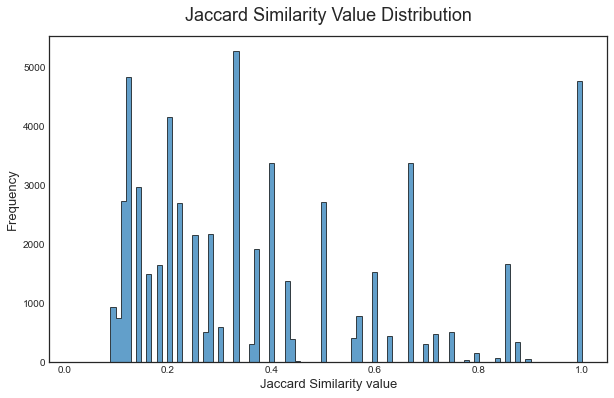

In [48]:
num_bins = 100
plt.style.use('seaborn-white')
plt.figure(figsize=(10,6))
plt.title('Jaccard Similarity Value Distribution', size=18, pad=15)
plt.xlabel('Jaccard Similarity value', size=13)
plt.ylabel('Frequency', size=13)
kwargs = dict(histtype='stepfilled', alpha=0.7, density=False, bins=np.linspace(np.min(0.02), np.max(1.), num=num_bins), ec="k")
plt.hist(jac_sim.ravel(), **kwargs);

In [49]:
cutoff = 0.85

In [50]:
jac_sim[jac_sim < cutoff] = 0
jac_sim[jac_sim >= cutoff] = 1
np.count_nonzero(jac_sim)

6813

- 대각 성분은 0으로 변환(GCN 수행 시 다시 1로 변환돰).

In [51]:
np.fill_diagonal(jac_sim, 0)

- sparse matrix로 변환 후 저장.

In [52]:
space_adj_jac = sp.csr_matrix(jac_sim)

In [53]:
# with open('space.graph.jac.0.85', 'wb') as f:
#     pkl.dump(space_adj_jac, f)

- Cosine similarity를 이용해 인접 부재 유사도 계산.

In [167]:
cos= pairwise_distances(adjv, metric='cosine')
cos_sim= 1-cos

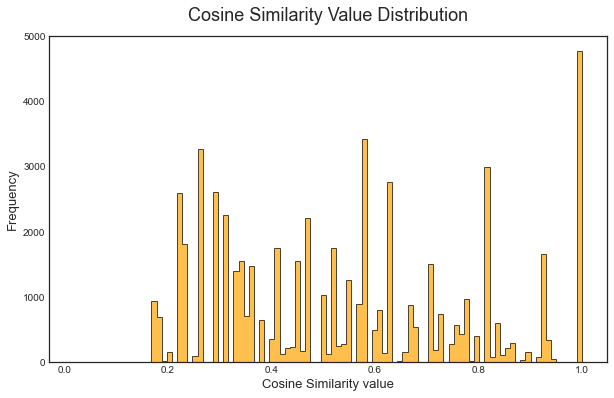

In [168]:
num_bins = 100
plt.style.use('seaborn-white')
plt.figure(figsize=(10,6))
plt.title('Cosine Similarity Value Distribution', size=18, pad=15)
plt.xlabel('Cosine Similarity value', size=13)
plt.ylabel('Frequency', size=13)
kwargs = dict(histtype='stepfilled', alpha=0.7, density=False, bins=np.linspace(np.min(0.02), np.max(1.), num=num_bins), ec="k", color = "orange")
plt.hist(cos_sim.ravel(), **kwargs);

In [128]:
cutoff = 0.85

In [129]:
cos_sim[cos_sim < cutoff] = 0
cos_sim[cos_sim >= cutoff] = 1
np.count_nonzero(cos_sim)

7567

- 대각 성분은 0으로 변환(GCN 수행 시 다시 1로 변환돰).

In [130]:
np.fill_diagonal(cos_sim, 0)

- sparse matrix로 변환 후 저장.

In [131]:
space_adj_cos = sp.csr_matrix(cos_sim)

In [132]:
# with open('space.graph.cos', 'wb') as f:
#     pkl.dump(space_adj_cos, f)

### Label 파일 저장

In [12]:
label = data_.iloc[:, -1]

In [13]:
label = label.values

In [14]:
# with open('space.labels', 'wb') as f:
#     pkl.dump(label, f)